Import relevant libraries

In [1]:
import numpy as np    
import pandas as pd                  
import matplotlib.pyplot as plt

Load the data


In [2]:
data = pd.read_csv('/content/digit-recognizer/train.csv')
data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
no_pix = data.shape[1]-1  
Digits = np.unique(data['label'])
print("Shape of Dataset {}".format(data.shape))
print("Number of Images {}".format(data.shape[0]) )

Shape of Dataset (42000, 785)
Number of Images 42000


In [4]:
train_labels = np.array(data['label']).reshape(data.shape[0],1)
print("Shape of Labels   = {}".format(train_labels.shape))

train_dataset = np.array(data.iloc[:,1:785]).reshape(data.shape[0],784)
print("Shape of Features = {}".format(train_dataset.shape))

Shape of Labels   = (42000, 1)
Shape of Features = (42000, 784)


Plot random numbers

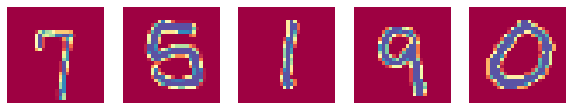

In [5]:
images = np.array(train_dataset[50:55,:]).reshape(5,28,28,1)   

plt.figure(figsize=(10,20))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i,:,:,0],cmap='Spectral')
    plt.axis("off")

Seperate the data into training, validation and test data


In [6]:
test_dataset = np.array(train_dataset[36000:42000]).reshape(-1,no_pix)
test_labels = np.array(train_labels[36000:42000]).reshape(-1,1)

valid_dataset = np.array(train_dataset[30000:36000]).reshape(-1,no_pix)
valid_labels = np.array(train_labels[30000:36000]).reshape(-1,1)

train_dataset = np.array(train_dataset[0:30000]).reshape(-1,no_pix)
train_labels = np.array(train_labels[0:30000]).reshape(-1,1)

print("Train dataset = {}".format(train_dataset.shape,train_labels.shape))
print("Valid dataset = {}".format(valid_dataset.shape,valid_labels.shape))
print("Test dataset  = {}".format(test_dataset.shape,test_labels.shape))

Train dataset = (30000, 784)
Valid dataset = (6000, 784)
Test dataset  = (6000, 784)


One-Hot encoding

In [7]:
neural_train_labels = np.zeros((train_labels.shape[0],10))
neural_valid_labels = np.zeros((valid_labels.shape[0],10))
neural_test_labels = np.zeros((test_labels.shape[0],10))

for i,value in enumerate(train_labels):
    neural_train_labels[i,value] = 1

for i,value in enumerate(valid_labels):
    neural_valid_labels[i,value] = 1

for i,value in enumerate(test_labels):
    neural_test_labels[i,value] = 1

Convert the 784 pixels into 28*28

In [8]:
#Define the hyper-parameters
no_channel = 1 
depth = 4
eta = 0.1
beta = 0

def transform(d):
    d = d.reshape(-1,28,28,no_channel).astype(np.float32)
    return d

train_dataset = transform(train_dataset)
valid_dataset = transform(valid_dataset)
test_dataset = transform(test_dataset)

print('Training set   = {}'.format(train_dataset.shape, neural_train_labels.shape))
print('Validation set = {}'.format(valid_dataset.shape, neural_valid_labels.shape))
print('Test set       = {}'.format(test_dataset.shape, neural_test_labels.shape))

Training set   = (30000, 28, 28, 1)
Validation set = (6000, 28, 28, 1)
Test set       = (6000, 28, 28, 1)


Define the activation functions

In [9]:
def sigmoid(X):
    return 1/(1+np.exp(-1*X))

def softmax(X):
    e = np.exp(X);
    s = np.sum(e,1).reshape(-1,1)  #col-wise sum
    e = e/s
    return e

In [10]:

def initialize_param():
    #initialize weights values with 0 mean and 0.5 standard deviation.
    mean = 0
    std = 0.5
    
    #conv layer weights
    cl1_w = np.random.normal(mean,std,(3,3,no_channel,depth))
    cl1_b = np.zeros([1,depth])
    cl2_w = np.random.normal(mean,std,(3,3,depth,depth*4))
    cl2_b = np.zeros([1,depth*4])
    
    #fully-connected weights
    full_l1_w = np.random.normal(mean,std,(((28//4-1) * (28//4-1) * depth * 4),256))
    full_l1_b = np.zeros([256])
    full_l2_w = np.random.normal(mean,std,(256,10))
    full_l2_b = np.zeros([10])
    
    param = dict()
    param['cw1'] = cl1_w
    param['cb1'] = cl1_b
    param['cw2'] = cl2_w
    param['cb2'] = cl2_b
    param['fw1'] = full_l1_w
    param['fb1'] = full_l1_b
    param['fw2'] = full_l2_w
    param['fb2'] = full_l2_b
    
    return param

In [11]:
def conv_multiply(image,weights):
    hsize = (image.shape[0]-weights.shape[0])//2 + 1
    vsize = (image.shape[1]-weights.shape[1])//2 + 1
    logits = np.zeros([hsize,vsize,weights.shape[3]])
    for d in range(weights.shape[3]):
        row = 0
        for rpos in range(0,(image.shape[0]-3+1),2):
            col=0
            for cpos in range(0,(image.shape[1]-3+1),2):
                logits[row,col,d] = np.sum(np.multiply(image[rpos:rpos+3, cpos:cpos+3, :],weights[:,:,:,d]))
                col += 1
            row+=1
    return logits

In [12]:
def forward_propagation(dataset,param):
    #convolution layers activations
    m = dataset.shape[0]
    
    #get the param
    cw1 = param['cw1']
    cb1 = param['cb1']
    cw2 = param['cw2']
    cb2 = param['cb2']
    
    fw1 = param['fw1']
    fb1 = param['fb1']
    fw2 = param['fw2']
    fb2 = param['fb2']
    
    #to store the intermediate activations for backward propagation
    cache = dict()
    
    conv_activation1 = list()
    conv_activation2 = list()
    
    #image by image convolutional forward propagation
    for i in range(m):
        image = dataset[i]
        logits = conv_multiply(image,cw1) + cb1
        ca1 = sigmoid(logits)
        ca2 = sigmoid(conv_multiply(ca1,cw2) + cb2).reshape((28 // 4 -1) * (28 // 4 -1) * depth * 4)
        
        conv_activation1.append(ca1)
        conv_activation2.append(ca2)
        
    #convert into numpy array
    conv_activation1 = np.array(conv_activation1).reshape(m,28 // 2 -1, 28 // 2 -1, depth)
    conv_activation2 = np.array(conv_activation2).reshape(m,28 // 4 -1, 28 // 4 -1, depth * 4)
        
    #expand the conv_activation2 into (m,num_features) 
    #num_features = (28 // 4 * 28 // 4 * depth * 4)
    temp_activation = np.array(conv_activation2).reshape(m,(28 // 4 -1) * (28 // 4-1) * depth * 4)
    
    #fully connected layers activations
    full_activation1 = np.matmul(temp_activation,fw1) + fb1
    full_activation1 = sigmoid(full_activation1)
    full_activation2 = np.matmul(full_activation1,fw2) + fb2
    output = softmax(full_activation2)

    cache['ca1'] = conv_activation1
    cache['ca2'] = conv_activation2
    cache['fa1'] = full_activation1
    cache['output'] = output
    return cache,output

In [13]:
def conv_delta(next_error,weights):
    delta = np.zeros([next_error.shape[0]*2+1,next_error.shape[1]*2+1,next_error.shape[2]//4])
    for d in range(weights.shape[3]):
        row = 0
        for rpos in range(0,delta.shape[0]-3+1,2):
            col=0
            for cpos in range(0,delta.shape[2]-3+1,2):
                delta[rpos:rpos+3,cpos:cpos+3,:] += weights[:,:,:,d]*next_error[row,col,d]
                col+=1
            row +=1
    return delta

In [14]:
def conv_derivatives(delta,activation):
    partial_derivatives = np.zeros([3,3,activation.shape[2],delta.shape[2]])
    for d2 in range(0,partial_derivatives.shape[3]):
        row=0
        for rpos in range(0,activation.shape[0]-3+1,2):
            col = 0
            for cpos in range(0,activation.shape[1]-3+1,2):
                partial_derivatives[:,:,:,d2] += np.multiply(activation[rpos:rpos+3, cpos:cpos+3, :],delta[row,col,d2])
                col += 1
            row += 1
    return partial_derivatives

In [15]:
def backward_propagation(dataset,labels,cache,param):
    #get activations
    output = cache['output']
    fa1 = cache['fa1']
    ca2 = cache['ca2']
    ca1 = cache['ca1']
    
    temp_act = np.array(ca2).reshape(-1,(28 // 4-1) * (28 // 4 -1)* depth * 4)
    
    #get param
    cw1 = param['cw1']
    cw2 = param['cw2']
    fw1 = param['fw1']
    fw2 = param['fw2']
    
    
    #cal errors fully connected
    error_fa2 = output - labels
    error_fa1 = np.matmul(error_fa2,fw2.T)
    error_fa1 = np.multiply(error_fa1,fa1)
    error_fa1 = np.multiply(error_fa1,(1-fa1))
    error_temp = np.matmul(error_fa1,fw1.T)
    error_temp = np.multiply(error_temp,temp_act)
    error_temp = np.multiply(error_temp,(1-temp_act))
    
    m = dataset.shape[0]
    
    #cal errors conv layers
    error_ca2 = np.array(error_temp).reshape(-1,28//4-1,28//4-1,depth*4)
    error_ca1 = np.zeros(ca1.shape)
    ## Image by Image error
    for i in range(m):
        error = conv_delta(error_ca2[i],cw2)
        error = np.multiply(error,ca1[i])
        error = np.multiply(error,(1-ca1[i]))
        error_ca1 += error
    
    
    #calculate partial derivatives
    #fully connected layers
    fd2 = (np.matmul(fa1.T,error_fa2) + beta*fw2)/m
    fd1 = (np.matmul(temp_act.T,error_fa1) + beta*fw1)/m
    
    #conv layers
    cd2 = np.zeros(cw2.shape)
    cd1 = np.zeros(cw1.shape)
    
    ##Image by Image derivatives
    for i in range(m):
        cd2 = cd2 + conv_derivatives(error_ca2[i],ca1[i])
        cd1 = cd1 + conv_derivatives(error_ca1[i],dataset[i])
    cd2 = (cd2 + beta*cw2)/m
    cd1 = (cd1 + beta*cw1)/m
    
    
    #store the derivatives in dict
    derivatives = dict()
    derivatives['cd1'] = cd1
    derivatives['cd2'] = cd2
    derivatives['fd1'] = fd1
    derivatives['fd2'] = fd2
    
    return derivatives

In [16]:
def update_param(derivatives,param):
    #get param
    cw1 = param['cw1']
    cw2 = param['cw2']
    fw1 = param['fw1']
    fw2 = param['fw2']
    
    #get derivatives
    cd1 = derivatives['cd1']
    cd2 = derivatives['cd2']
    fd1 = derivatives['fd1']
    fd2 = derivatives['fd2']
    
    #update
    cw1 = cw1 - eta*cd1
    cw2 = cw2 - eta*cd2
    fw1 = fw1 - eta*fd1
    fw2 = fw2 - eta*fd2
    
    #update the dict
    param['cw1'] = cw1
    param['cw2'] = cw2
    param['fw1'] = fw1
    param['fw2'] = fw2
    
    return param

In [17]:
def cal_loss_accuracy(true_labels,predictions,param):
    
    cw1 = param['cw1']
    cw2 = param['cw2']
    fw1 = param['fw1']
    fw2 = param['fw2']
    
    m = len(true_labels)
    
    #calculate loss
    loss = -1*(np.sum(np.multiply(np.log(predictions),true_labels),1) + np.sum(np.multiply(np.log(1-predictions),1-true_labels),1))
    loss = np.sum(loss)
    loss = loss + beta*(np.sum(cw1**2) + np.sum(cw2**2) + np.sum(fw1**2) + np.sum(fw2**2))
    loss = loss/m
    
    #calculate accuracy
    accuracy = np.sum(np.argmax(true_labels,1)==np.argmax(predictions,1))/m
    
    return loss,accuracy

In [18]:
def train(train_dataset,train_labels,batch_size=20,iters=101,stride=2):
    
    #initialize the param
    param = initialize_param()
    
    cw1 = param['cw1']
    cb1 = param['cb1']
    cw2 = param['cw2']
    cb2 = param['cb2']
    
    fw1 = param['fw1']
    fb1 = param['fb1']
    fw2 = param['fw2']
    fb2 = param['fb2']
    
    L = []  #store the loss of every batch
    A = []  #store the accuracy of every batch
    
    
    #training process.
    for step in range(iters):
        #get the batch data.
        start = (step*batch_size)%(train_dataset.shape[0])
        end = start + batch_size
        
        batch_dataset = train_dataset[start:end,:,:,:]
        batch_labels = train_labels[start:end,:]
        
        #forward propagation
        cache,output = forward_propagation(batch_dataset,param)
        
        #cal_loss and accuracy
        loss,accuracy = cal_loss_accuracy(batch_labels,output,param)
        
        #calculate the derivatives
        derivatives = backward_propagation(batch_dataset,batch_labels,cache,param)
        
        #update the param
        param = update_param(derivatives,param)
        
        #append the loss and accuracy of every batch
        L.append(loss)
        A.append(accuracy)
        
        #print loss and accuracy of the batch dataset.
        if(step%100==0):
            print('Step : %d'%step)
            print('Loss : %f'%loss)
            print('Accuracy : %f%%'%(round(accuracy*100,2)))
            
    return L,A,param

In [19]:
L,A,param = train(train_dataset,neural_train_labels,iters=1501)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Step : 0
Loss : 10.387145
Accuracy : 5.000000%
Step : 100
Loss : 3.279462
Accuracy : 20.000000%
Step : 200
Loss : 1.524651
Accuracy : 65.000000%
Step : 300
Loss : 1.091180
Accuracy : 85.000000%
Step : 400
Loss : 1.061423
Accuracy : 75.000000%
Step : 500
Loss : 1.040706
Accuracy : 75.000000%
Step : 600
Loss : 1.036102
Accuracy : 70.000000%
Step : 700
Loss : 1.040974
Accuracy : 80.000000%
Step : 800
Loss : 1.783848
Accuracy : 55.000000%
Step : 900
Loss : 1.673284
Accuracy : 65.000000%
Step : 1000
Loss : 1.109639
Accuracy : 70.000000%
Step : 1100
Loss : 1.591129
Accuracy : 80.000000%
Step : 1200
Loss : 0.332197
Accuracy : 100.000000%
Step : 1300
Loss : 0.648719
Accuracy : 85.000000%
Step : 1400
Loss : 1.278205
Accuracy : 75.000000%
Step : 1500
Loss : 0.382752
Accuracy : 95.000000%


Measure the accuracy on test data

In [20]:
_,test_pred = forward_propagation(test_dataset,param)
_,test_accuracy = cal_loss_accuracy(neural_test_labels,test_pred,param)
print('Accuracy = {}'.format(round(test_accuracy*100,2)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Accuracy = 81.57


Check the MODEL predictions

(36, 1, 28, 28)


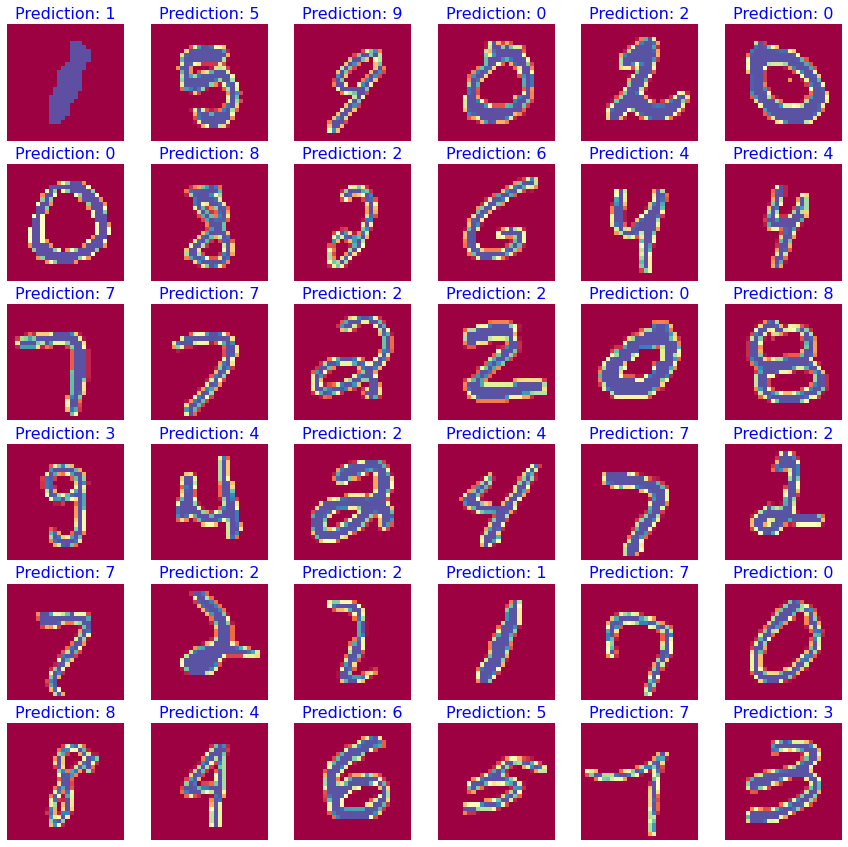

In [24]:
images = test_dataset[0:36]
images = images.reshape(36, 1, 28, 28)
test_pred = neural_test_labels[0:36]
print(images.shape)
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(15, 15))
for i, image in enumerate(images):
     image = image.reshape(28, 28)
     ax[i//6][i%6].axis('off')
     ax[i//6][i%6].imshow(image, cmap='Spectral')
     ax[i//6][i%6].set_title(f"Prediction: {np.argmax(test_pred[i])}",
fontsize=16, color='blue')